AAI-500 Spring 2024 Final Project
Group 1

Members:
>Arup<br>
>Issa<br>
>Geoffrey<br>

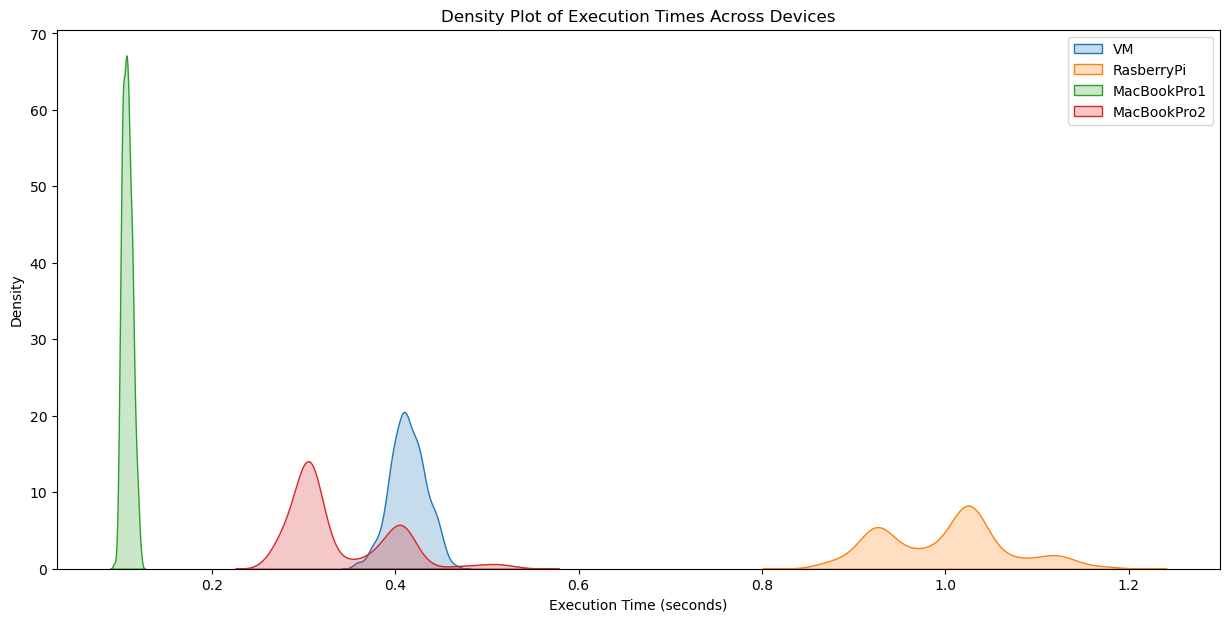

Levene's Test p-value   : 0.00017185030169415284
ANOVA Test p-value      : 0.0

We reject the null hypothesis: There is a significant difference in execution times across devices.


In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Get the directory where the script is located
script_dir = os.path.dirname('.')  # This gets the directory where the script is located

# Define a function to clean and filter each dataset
def clean_and_filter_dataset(file_name):
    file_path = os.path.join(script_dir, file_name)  # Construct the full file path
    df = pd.read_csv(file_path)
    
    # Optionally drop the 'Time' column if it's not needed for further analysis
    if 'Time' in df.columns:
        df.drop('Time', axis=1, inplace=True)
    
    # Calculate Q1, Q3, and IQR for 'Execution Time'
    Q1 = df['Execution Time'].quantile(0.25)
    Q3 = df['Execution Time'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    filtered_df = df[(df['Execution Time'] >= lower_bound) & (df['Execution Time'] <= upper_bound)]
    
    # Save the filtered DataFrame to a new CSV file
    filtered_file_path = os.path.join(script_dir, file_name.split('.')[0] + '_filtered.csv')
    filtered_df.to_csv(filtered_file_path, index=False)
    
    return filtered_df

# Names of the dataset files
file_names = ['VM.csv', 'RasberryPi.csv', 'MacBookPro1.csv', 'MacBookPro2.csv']
device_names = ['VM', 'RaspberryPi', 'MacBookPro1', 'MacBookPro2']

# Loop through each file name, clean, filter, and plot
plt.figure(figsize=(15, 7))
for file_name in file_names:
    df = clean_and_filter_dataset(file_name)
    sns.kdeplot(df['Execution Time'], fill=True, label=file_name.split('.')[0])

plt.title('Density Plot of Execution Times Across Devices')
plt.xlabel('Execution Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()


# Load and combine datasets
combined_data = pd.DataFrame()
for file_name, device_name in zip(file_names, device_names):
    temp_df = pd.read_csv(os.path.join(script_dir, file_name))
    temp_df['Device'] = device_name
    combined_data = pd.concat([combined_data, temp_df], ignore_index=True)

# Significance level
alpha = 0.05

# Homogeneity of variances (Levene's Test)
stat, p_val_levene = stats.levene(combined_data['Execution Time'][combined_data['Device'] == 'VM'],
                                  combined_data['Execution Time'][combined_data['Device'] == 'RaspberryPi'],
                                  combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro1'],
                                  combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro2'])

print(f"Levene's Test p-value   : {p_val_levene}")


# ANOVA Test
anova_result = stats.f_oneway(combined_data['Execution Time'][combined_data['Device'] == 'VM'],
                              combined_data['Execution Time'][combined_data['Device'] == 'RaspberryPi'],
                              combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro1'],
                              combined_data['Execution Time'][combined_data['Device'] == 'MacBookPro2'])

print(f"ANOVA Test p-value      : {anova_result.pvalue}")
print()

# Interpret results with an if statement
if anova_result.pvalue < alpha:
    print("We reject the null hypothesis: There is a significant difference in execution times across devices.")
else:
    print("We fail to reject the null hypothesis: There is no significant difference in execution times across devices.")



<Axes: xlabel='Execution Time', ylabel='Density'>

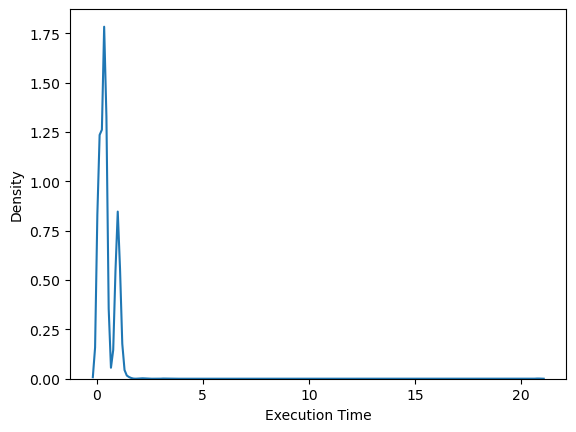

In [54]:
combined_data.head()
sns.kdeplot(combined_data['Execution Time'])

**Predictive Model**

**Major assumption:** In deriving the following model, we assume that the execution time does not increase/decrease with time. We assume that any PC will always take the same amount of time to execute an image recognition task no matter how long that PC has been running, no matter the PC configuration. (Contrary to common belief that a PC slows down over time)

Working on this assumption, we can then remove the timestamp from the original data, and assume that each data point is independent of each other.

As shown above, the execution time density plots for MacBookPro1 and VM show bell-shaped distributions. This supports our assumption that each observation is independent of time.

However, MacBookPro2 and RaspBerry Pi are showing 'multiple' normal distribution plots with different means. Sometimes the task takes longer, sometimes it's quicker.

Since the PC configuration (exploratory variables in this study) is constant, there must be other factors that made the density plot look like that. One possibility is time - i.e As time goes on, the same task will take longer to execute on any PC following a certain trend, and this trend might be dependent on the the PC configuration. Another explanation could be of data collection error - i.e maybe other tasks were executed on these machines resulting in an increase in observed execution time

For the scope of this study, however, we proceed with our assumption that progress time is not factor for our model, and so we use the GLM to predict:

> $y$ : execution time in seconds

based on the variables:

> $x_{1}$ : CPU Clock Speed in GHz

> $x_{2}$ : CPU core count

> $x_{3}$ : RAM Size

In the following analysis, we explore:

> (1) GLM with no transformation of input variable $x_{3}$

> (2) GLM with $x_{3}$ transformed



**Case 1**
No transformation for RAM size.


Note: RAM sizes are always a power of 2 - i.e. 2, 4, 8, 16, 32GB. To better expose its linear relationship with the execution time, we think it is worth exploring a glm by transforming this variable to $log_{2}$(RAM Size). See Case 2 below

In [48]:
VM = clean_and_filter_dataset('VM.csv')
Mac1 = clean_and_filter_dataset('MacBookPro1.csv')
Mac2 = clean_and_filter_dataset('MacBookPro2.csv')
RasPi = clean_and_filter_dataset('RasberryPi.csv')

We then create a unified table with $x_{1}, x_{2}, x_{3}, y$ using the folloing information

<table>
  <thead>
    <tr>
      <th>PC Label</th>
      <th>CPU Clock Speed (GHz)</th>
      <th>CPU Core Count</th>
      <th>RAM Size, no transformation</th>
        <th>RAM Size, with transformation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>MacBookPro1</td>
      <td>1.4</td>
      <td>4</td>
      <td>8</td>
      <td>$log_{2}$(8) = 3</td>
    </tr>
    <tr>
      <td>MacBookPro2</td>
      <td>2.5</td>
      <td>2</td>
       <td>8</td>
      <td>$log_{2}$(8) = 3</td>
    </tr>
      <tr>
      <td>RaspBerry Pi</td>
      <td>1.8</td>
      <td>4</td>
      <td>4</td>
      <td>$log_{2}$(4) = 2</td>
    </tr>
  </tbody>
</table>

In [49]:
sizeOfData = 300
clock = []
core = []
ram = []
exeTime = []

#The objective is to create a unified table with columns "clock", "core", "ram", "execution time"
#sizeOfData samples are taken from each compute (MacBook1, 2, and RaspBerryPi in that order.
#clock, core and ram columns are filled in with values according to the table above)

clock = np.concatenate([np.concatenate([1.4*np.ones(sizeOfData), 2.5*np.ones(sizeOfData)]),1.8*np.ones(sizeOfData)])

core = np.concatenate([np.concatenate([4*np.ones(sizeOfData), 2*np.ones(sizeOfData)]),4*np.ones(sizeOfData)])

ram = np.concatenate([np.concatenate([8*np.ones(sizeOfData), 8*np.ones(sizeOfData)]),4*np.ones(sizeOfData)])

exeTime = np.concatenate([np.concatenate([Mac1[0:sizeOfData],Mac2[0:sizeOfData]]), RasPi[0:sizeOfData]])

exeTime = np.array(exeTime).flatten()
#for some reason, on Jupyter notebook kernel, exeTime above results in an array of array values.
#Without flattening: exeTime = [[val1] [val2] [val3]...]
#With flattening: exeTime = [val1 val2 val3...]

combined = {'clock' : clock,
        'core' : core,
        'ram' : ram,
        'time' : exeTime} 


combined = pd.DataFrame(combined)

model= smf.glm(formula = 'time ~ clock + core + ram', family = sm.families.Gaussian(), data = combined).fit()
print(model.summary())
print("AIC no x3 transformation: ", model.aic)




                 Generalized Linear Model Regression Results                  
Dep. Variable:                   time   No. Observations:                  900
Model:                            GLM   Df Residuals:                      897
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                       0.0020478
Method:                          IRLS   Log-Likelihood:                 1510.4
Date:                Sat, 24 Feb 2024   Deviance:                       1.8368
Time:                        03:31:37   Pearson chi2:                     1.84
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1292      0.000    262.390      0.0

**Analysis:** 

In the model above, an increase in "1GB" in RAM size means a reduction of 0.1706 seconds in the execution time. However, RAMs come in fixed sizes. When evaluating the change in performance of a PC by changing the RAM size from 4GB to 8GB, the effect must be multiplied by 4. When changing the RAM size from 2GB to 4GB, the effect must be multiplied by 2. 

Unexpectedly, an increase of 1GHz on the CPU Clock speed, or a unit increase on the CPU Core count, were found to increase the execution time of an image processing task in this model. All coefficients were found significant
<br>

**Case 2: If RAM size was transformed**
>$x_{3}$ is computed as $log_{2}$(RAM size)^{1}

Note: RAM sizes are always a power of 2 - i.e. 2, 4, 8, 16, 32GB. To better expose its linear relationship with the execution time, we think it is worth exploring a glm by transforming this variable to $log_{2}$(RAM Size)

In [51]:
ram2 = np.concatenate([np.concatenate([3*np.ones(sizeOfData), 3*np.ones(sizeOfData)]),2*np.ones(sizeOfData)])

combined2 = {'clock' : clock,
        'core' : core,
        'ram' : ram2,
        'time' : exeTime} 


combined2 = pd.DataFrame(combined2)

model2= smf.glm(formula = 'time ~ clock + core + ram', family = sm.families.Gaussian(), data = combined2).fit()
print(model2.summary())
print("AIC with x3 transformation: ", model2.aic)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   time   No. Observations:                  900
Model:                            GLM   Df Residuals:                      897
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                       0.0020478
Method:                          IRLS   Log-Likelihood:                 1510.4
Date:                Sat, 24 Feb 2024   Deviance:                       1.8368
Time:                        04:03:01   Pearson chi2:                     1.84
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1097      0.000    261.453      0.0

**Analysis:** 

In the model above, a "unit" increase in RAM configuration (2GB to 4GB, 4GB to 8GB, etc) causes a decrease of 0.6238 seconds in the execution time, adjusting for CPU clock speed and core count. 

Just by the transformation of $x_{3}$, the RAM size effect became higher while the effects of the other variables remained relatively similar to case1.

<br>

**Analysis:**

Since the AICs of both models above are equal in value, we are compelled to conclude that either model are effective in predicting the execution time.

HOWEVER,

In the current data set, the RAM size only has two values - i.e. 4GB, or 8GB.
Even when it is log transformed, it would still only have two values, 2 or 3.
Meanwhile, commercially, RAM size $\epsilon$ {2, 4, 8, 16, 32}

If we have data from all these RAM size variations, we assume that the GLM using log-transformed RAM size would get a better/lower AIC.




**Case 3: If interaction between RAM size and CPU clock speed was allowed**


Note: RAM sizes are always a power of 2 - i.e. 2, 4, 8, 16, 32GB. To better expose its linear relationship with the execution time, we think it is worth exploring a glm by transforming this variable to $log_{2}$(RAM Size)Insert More Post Analysis Plots below like Residual